# Joint LSTM Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import time
import itertools
from tqdm import tqdm
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
input_directory = r"C:\Users\sb013698\Desktop\github\Hybrid UBEM Tool\Time-Series Prediction\Datasets"
building_list = ["AB1", "AB2", "AB3", "AB4", "SCOLA", "OM", "SM", "Y1", "Y2", "Y3", "Y4-5", "Y6", "GH"]

column_order = [
    'Energy (kWh)', 'Month', 'Day', 'Hours', 'Building Name', 'Archetype',
    'Year Built', 'Heating Schedule', 'Cooling Schedule', 'DHW Schedule',
    'Equipment Schedule', 'Lighting Schedule', 'Occupancy Schedule',
    'Natural Ventilation Schedule', 'DHW Flow Rate (m3/h/m2)',
    'EPD (kWh/m2)', 'LPD (kWh/m2)', 'Occupant Density',
    'DHW Density', 'EQP Density', 'Lighting Density',
    'Occupant Load Density', 'Heating Delta_T', 'Cooling Delta_T',
    'Heating Set Point', 'Cooling Set Point', 'Dry Bulb Temperature {C}',
    'Dew Point Temperature {C}', 'Relative Humidity {%}',
    'Wind Direction (deg)', 'Wind Speed (m/s)',
    'Hourly Total Global Solar Radiation (watt/m2)',
    'Liquid Precipitation (mm)', 'Sun Exposure Intensity (cal/cm2)',
    'GFA (m2)', 'Rhino GFA (m2)', 'WWR (%)', 'Window-to-Concrete Ratio',
    'Height (m)', 'wall u-value', 'roof u-value', 'ground u-value',
    'slab u-value', 'window u-value', 'Infiltration',
    'Window Radiation (kWh)',
]

print(len(column_order))

46


In [4]:
# Merge Individual Datasets
# Initialize a joint_df
joint_df = pd.DataFrame()

for b in building_list:
    
    file_name = os.path.join(input_directory, f"{b}.xlsx")
    data = pd.read_excel(file_name)
    
    # Check if the columns of data present in the column_order list
    count_column = 0
    for c in data.columns:
        if c in column_order:
            count_column += 1
        else:
            #print(f"PROBLEM: {c} is not in the column_order!")
            pass
            
    # Check if the columns of data have missing values
    count_missing = 0
    for c in data.columns:
        if data[c].isnull().sum() == 0:
            pass
        else:
            count_missing += 1
            #print(f"PROBLEM: {c} has missing values!")
    print(b, count_column, count_missing, "\n>>>>")
    
    if count_column == len(column_order) and count_missing == 0:
        # Concatenate the current data to the joint_df
        joint_df = pd.concat([joint_df, data[column_order]], ignore_index=True)

AB1 46 0 
>>>>
AB2 46 0 
>>>>
AB3 46 0 
>>>>
AB4 46 0 
>>>>
SCOLA 46 0 
>>>>
OM 46 0 
>>>>
SM 46 0 
>>>>
Y1 46 0 
>>>>
Y2 46 0 
>>>>
Y3 46 0 
>>>>
Y4-5 46 0 
>>>>
Y6 46 0 
>>>>
GH 46 0 
>>>>


In [5]:
# Define categorical columns
categorical_columns = ['Month', 'Day', 'Hours', 'Building Name', 'Archetype']
new_df = joint_df.copy()
new_df['Month'] = joint_df['Month'].astype('category')
new_df['Day'] = joint_df['Day'].astype('category')
new_df['Hours'] = joint_df['Hours'].astype('category')
new_df['Building Name'] = joint_df['Building Name'].astype('category')
new_df['Archetype'] = joint_df['Archetype'].astype('category')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113880 entries, 0 to 113879
Data columns (total 46 columns):
 #   Column                                         Non-Null Count   Dtype   
---  ------                                         --------------   -----   
 0   Energy (kWh)                                   113880 non-null  float64 
 1   Month                                          113880 non-null  category
 2   Day                                            113880 non-null  category
 3   Hours                                          113880 non-null  category
 4   Building Name                                  113880 non-null  category
 5   Archetype                                      113880 non-null  category
 6   Year Built                                     113880 non-null  int64   
 7   Heating Schedule                               113880 non-null  float64 
 8   Cooling Schedule                               113880 non-null  int64   
 9   DHW Schedule              

In [6]:
new_df.shape

(113880, 46)

In [7]:
new_df = pd.get_dummies(new_df)
new_df.shape

(113880, 125)

In [8]:
new_df.head()

,Energy (kWh),Year Built,Heating Schedule,Cooling Schedule,DHW Schedule,Equipment Schedule,Lighting Schedule,Occupancy Schedule,Natural Ventilation Schedule,DHW Flow Rate (m3/h/m2),EPD (kWh/m2),LPD (kWh/m2),Occupant Density,DHW Density,EQP Density,Lighting Density,Occupant Load Density,Heating Delta_T,Cooling Delta_T,Heating Set Point,Cooling Set Point,Dry Bulb Temperature {C},Dew Point Temperature {C},Relative Humidity {%},Wind Direction (deg),Wind Speed (m/s),Hourly Total Global Solar Radiation (watt/m2),Liquid Precipitation (mm),Sun Exposure Intensity (cal/cm2),GFA (m2),Rhino GFA (m2),WWR (%),Window-to-Concrete Ratio,Height (m),wall u-value,roof u-value,ground u-value,slab u-value,window u-value,Infiltration,Window Radiation (kWh),Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,Hours_0,Hours_1,Hours_2,Hours_3,Hours_4,Hours_5,Hours_6,Hours_7,Hours_8,Hours_9,Hours_10,Hours_11,Hours_12,Hours_13,Hours_14,Hours_15,Hours_16,Hours_17,Hours_18,Hours_19,Hours_20,Hours_21,Hours_22,Hours_23,Building Name_AB1,Building Name_AB2,Building Name_AB3,Building Name_AB4,Building Name_GH,Building Name_OM,Building Name_SCOLA,Building Name_SM,Building Name_Y1,Building Name_Y2,Building Name_Y3,Building Name_Y4-5,Building Name_Y6,Archetype_Academic Building,Archetype_Dormitory,Archetype_Social Building,Archetype_Sports Center
0,0.000000,2012,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000111,8.75,5.0,0.0678,0.0,0.000,0.0,0.0,0.0,0.0,21,24.5,1.5,1.5,100,180,0.9,0,0.0,0.0,22935.0,45063,0.281437,0.215794,24.0,0.27492,0.313775,1.73913,2.283105,2.4,0.3,0.0,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,0.000000,2012,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000111,8.75,5.0,0.0678,0.0,0.000,0.0,0.0,0.0,0.0,21,24.5,0.5,0.5,100,158,1.2,0,0.0,0.0,22935.0,45063,0.281437,0.215794,24.0,0.27492,0.313775,1.73913,2.283105,2.4,0.3,0.0,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,0.000000,2012,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000111,8.75,5.0,0.0678,0.0,0.000,0.0,0.0,0.0,0.0,21,24.5,0.8,0.8,100,180,1.2,0,0.0,0.0,22935.0,45063,0.281437,0.215794,24.0,0.27492,0.313775,1.73913,2.283105,2.4,0.3,0.0,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,61.961858,2012,0.0,0,0.0,0.1,0.1,0.0,0.0,0.000111,8.75,5.0,0.0678,0.0,0.875,0.5,0.0,0.0,0.0,21,24.5,1.3,1.0,98,180,1.0,0,0.0,0.0,22935.0,45063,0.281437,0.215794,24.0,0.27492,0.313775,1.73913,2.283105,2.4,0.3,0.0,True,False,False,False,False,False,False,False,False,False,Fal

In [9]:
new_df["Energy (kWh)"].describe()

count    113880.000000
mean        358.766755
std         428.699382
min           0.000000
25%          30.513795
50%         212.835781
75%         553.319343
max        3524.681469
Name: Energy (kWh), dtype: float64

In [10]:
# Transform zero entries into one (kWh)
min_value = 1
new_df["Energy (kWh)"] = new_df["Energy (kWh)"].apply(lambda x: min_value if x < min_value else x)

new_df["Energy (kWh)"].describe()

count    113880.000000
mean        358.976406
std         428.524087
min           1.000000
25%          30.513795
50%         212.835781
75%         553.319343
max        3524.681469
Name: Energy (kWh), dtype: float64

In [11]:
# Normalize data except the target column
# Specify the column to be excluded from scaling
column_not_scaled = 'Energy (kWh)'
columns_to_scale = [col for col in new_df.columns if col != column_not_scaled]

# Extract the columns for scaling
subset_to_scale = new_df[columns_to_scale]

# Initialize and fit the scaler on the subset
scaler = StandardScaler()
scaler.fit(subset_to_scale)
scaled_subset = scaler.transform(subset_to_scale)

# Replace the original values with scaled values in the DataFrame
new_df[columns_to_scale] = scaled_subset

In [12]:
new_df.head()

,Energy (kWh),Year Built,Heating Schedule,Cooling Schedule,DHW Schedule,Equipment Schedule,Lighting Schedule,Occupancy Schedule,Natural Ventilation Schedule,DHW Flow Rate (m3/h/m2),EPD (kWh/m2),LPD (kWh/m2),Occupant Density,DHW Density,EQP Density,Lighting Density,Occupant Load Density,Heating Delta_T,Cooling Delta_T,Heating Set Point,Cooling Set Point,Dry Bulb Temperature {C},Dew Point Temperature {C},Relative Humidity {%},Wind Direction (deg),Wind Speed (m/s),Hourly Total Global Solar Radiation (watt/m2),Liquid Precipitation (mm),Sun Exposure Intensity (cal/cm2),GFA (m2),Rhino GFA (m2),WWR (%),Window-to-Concrete Ratio,Height (m),wall u-value,roof u-value,ground u-value,slab u-value,window u-value,Infiltration,Window Radiation (kWh),Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,Hours_0,Hours_1,Hours_2,Hours_3,Hours_4,Hours_5,Hours_6,Hours_7,Hours_8,Hours_9,Hours_10,Hours_11,Hours_12,Hours_13,Hours_14,Hours_15,Hours_16,Hours_17,Hours_18,Hours_19,Hours_20,Hours_21,Hours_22,Hours_23,Building Name_AB1,Building Name_AB2,Building Name_AB3,Building Name_AB4,Building Name_GH,Building Name_OM,Building Name_SCOLA,Building Name_SM,Building Name_Y1,Building Name_Y2,Building Name_Y3,Building Name_Y4-5,Building Name_Y6,Archetype_Academic Building,Archetype_Dormitory,Archetype_Social Building,Archetype_Sports Center
0,1.000000,-0.538126,-0.963357,-0.327645,-0.976288,-0.925317,-0.925317,-1.522231,-0.567568,-0.895916,0.96225,0.059748,1.086404,-0.666847,-0.912835,-0.729906,-1.169717,-0.796433,-0.259146,0.219971,0.288675,-1.698875,-1.359188,1.278739,-0.037672,-0.886024,-0.600317,-0.150048,-0.150048,0.603846,1.436978,-0.129167,-0.189124,0.626292,-0.536808,-0.352122,1.793729,0.732241,0.288675,-0.840149,-0.600823,3.282407,-0.288247,-0.304655,-0.299253,-0.304655,-0.299253,-0.304655,-0.304655,-0.299253,-0.304655,-0.299253,-0.304655,5.423713,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.176277,-0.176277,-0.139832,-0.208514,4.795832,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,3.464102,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,1.264911,-0.92582,-0.288675,-0.288675
1,1.000000,-0.538126,-0.963357,-0.327645,-0.976288,-0.925317,-0.925317,-1.522231,-0.567568,-0.895916,0.96225,0.059748,1.086404,-0.666847,-0.912835,-0.729906,-1.169717,-0.796433,-0.259146,0.219971,0.288675,-1.827486,-1.512579,1.278739,-0.215759,-0.686507,-0.600317,-0.150048,-0.150048,0.603846,1.436978,-0.129167,-0.189124,0.626292,-0.536808,-0.352122,1.793729,0.732241,0.288675,-0.840149,-0.600823,3.282407,-0.288247,-0.304655,-0.299253,-0.304655,-0.299253,-0.304655,-0.304655,-0.299253,-0.304655,-0.299253,-0.304655,5.423713,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.184376,-0.176277,-0.176277,-0.139832,-0.208514,-0.208514,4.795832,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,-0.208514,3.464102,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675

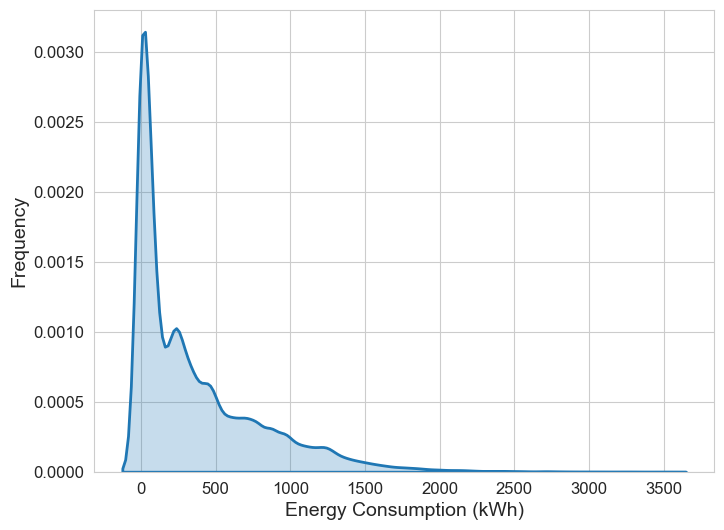

In [13]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.kdeplot(new_df["Energy (kWh)"], linewidth=2, fill=True)
plt.xlabel("Energy Consumption (kWh)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

# Create Sequences

In [14]:
# Initialize an empty dictionary to store building names and their indexes
building_indexes = {}

# Iterate over unique building names
for building_name in joint_df["Building Name"].unique():
    # Get indexes for the current building name
    indexes = joint_df[joint_df["Building Name"] == building_name].index.tolist()
    # Add the building name and its corresponding indexes to the dictionary
    building_indexes[building_name] = indexes
    
# Check if each list has the same shape and equals 8760
for i in building_indexes.keys():
    print(f"{i}: {len(building_indexes[i])}")

AB1: 8760
AB2: 8760
AB3: 8760
AB4: 8760
SCOLA: 8760
OM: 8760
SM: 8760
Y1: 8760
Y2: 8760
Y3: 8760
Y4-5: 8760
Y6: 8760
GH: 8760


In [15]:
# Define a sequence length
sequence_length = 12

main_sequences, main_targets = list(), list()

# Use the indexes from joint_df to create sequences from new_df
for building_name, index_list in building_indexes.items():
    
    current_df = new_df.loc[index_list, :]
    print(f"Shape of {building_name}: {current_df.shape}")
    
    # Create sequences and targets    
    sequences, targets = list(), list()
    
    for i in range(len(current_df) - sequence_length):
        seq = current_df.iloc[i:(i+sequence_length)].values
        # Assuming the target column is at index 0
        label = current_df.iloc[(i+sequence_length), 0]
        sequences.append(seq)
        targets.append(label)
        
    # Append the current sequences and targets to the main lists
    main_sequences.extend(sequences)
    main_targets.extend(targets)
    print(f"Sequence Length: {len(sequences)} & Target Length: {len(targets)}")
    print(">>>>")

# Convert main_sequences and main_targets to numpy arrays
main_sequences, main_targets = np.array(main_sequences), np.array(main_targets)

Shape of AB1: (8760, 125)
Sequence Length: 8748 & Target Length: 8748
>>>>
Shape of AB2: (8760, 125)
Sequence Length: 8748 & Target Length: 8748
>>>>
Shape of AB3: (8760, 125)
Sequence Length: 8748 & Target Length: 8748
>>>>
Shape of AB4: (8760, 125)
Sequence Length: 8748 & Target Length: 8748
>>>>
Shape of SCOLA: (8760, 125)
Sequence Length: 8748 & Target Length: 8748
>>>>
Shape of OM: (8760, 125)
Sequence Length: 8748 & Target Length: 8748
>>>>
Shape of SM: (8760, 125)
Sequence Length: 8748 & Target Length: 8748
>>>>
Shape of Y1: (8760, 125)
Sequence Length: 8748 & Target Length: 8748
>>>>
Shape of Y2: (8760, 125)
Sequence Length: 8748 & Target Length: 8748
>>>>
Shape of Y3: (8760, 125)
Sequence Length: 8748 & Target Length: 8748
>>>>
Shape of Y4-5: (8760, 125)
Sequence Length: 8748 & Target Length: 8748
>>>>
Shape of Y6: (8760, 125)
Sequence Length: 8748 & Target Length: 8748
>>>>
Shape of GH: (8760, 125)
Sequence Length: 8748 & Target Length: 8748
>>>>


In [16]:
print(f"Main Sequence Length: {main_sequences.shape} & Main Target Length: {main_targets.shape}")

Main Sequence Length: (113724, 12, 125) & Main Target Length: (113724,)


# Joint LSTM Model

In [17]:
# Define LSTM Models
# LSTM-1
class LSTMModel1(tf.keras.Model):
    def __init__(self, hidden_size, num_layers, output_size):
        super(LSTMModel1, self).__init__()
        self.lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.fc = tf.keras.layers.Dense(output_size)

    def call(self, x):
        out = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out

# LSTM-2
class LSTMModel2(tf.keras.Model):
    def __init__(self, hidden_size, num_layers, output_size):
        super(LSTMModel2, self).__init__()
        self.lstm_layers = [tf.keras.layers.LSTM(hidden_size, return_sequences=True) for _ in range(num_layers)]
        self.fc = tf.keras.layers.Dense(output_size)

    def call(self, x):
        for layer in self.lstm_layers:
            x = layer(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

## Hyperparameter Tuning

In [ ]:
train_size = 0.8
val_size = 0.1
test_size = 0.1

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    main_sequences, main_targets, test_size=(val_size+test_size), random_state=42,
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(test_size/(val_size+test_size)), random_state=42,
)

print("TRAIN-VALIDATION-TEST SIZES:")
print("Training:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

batch_size = 960

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=10000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [ ]:
# Create scenarios for hp tuning
lr_list = [1e-4, 5e-4, 1e-3, 5e-3]
num_layers = [2]
num_hidden_sizes = [63, 126, 189]
loss_function_list = ["mae", "mse"]
epoch_list = [50, 100, 150, 200, 250, 300]

combinations = list(itertools.product( 
    lr_list, 
    num_layers, 
    num_hidden_sizes,
    loss_function_list,
    epoch_list,
))

print("Number of Combinations:", len(combinations))
combinations[:10]

In [ ]:
# Create an empty list to store dictionaries
results_list = list()

# Iterate through different scenarios with tqdm
for combination in tqdm(
    combinations, 
    desc='Processing Scenarios', 
    unit='scenario', 
    position=0, 
    leave=True,
):
    
    lr, layer, hidden, loss_func, n_epoch = combination

    # Define an LSTM model
    hidden_size = hidden
    num_layers = layer
    output_size = 1
    model = LSTMModel2(hidden_size, num_layers, output_size)
        
    # Define Optimizer & Loss Function
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    if loss_func == "mae":
        model.compile(loss='mean_absolute_error', optimizer=optimizer)
    elif loss_func == "mse":
        model.compile(loss='mean_squared_error', optimizer=optimizer)
    else:
        print("Loss function is not valid!")
        
    # Model Training
    with tf.device('/device:GPU:0'):
        model.fit(train_dataset, epochs=n_epoch, verbose=0)
    
    # Evaluate the model on the validation data
    val_predictions = model.predict(val_dataset, verbose=0).flatten()
    
    # Calculate evaluation metrics for validation data
    val_r2 = r2_score(y_val, val_predictions)
    val_mae = mean_absolute_error(y_val, val_predictions)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_mape = mean_absolute_percentage_error(y_val, val_predictions)
    val_cvrmse = np.sqrt(val_mse) / np.mean(y_val)
    
    # Append results to the list
    result_dict = {
        'Learning Rate': lr,
        'Number of Layers': layer,
        'Number of Hidden Units': hidden,
        'Loss Function': loss_func,
        'Number of Epochs': n_epoch,
        'R2 Score': val_r2,
        'MSE': val_mse,
        'MAE': val_mae,
        "MAPE": val_mape,
        "CV-RMSE": val_cvrmse,
    }
    results_list.append(result_dict)
    
# Create a data frame from the list of dictionaries
result_df = pd.DataFrame(results_list)

## Model Evaluation

In [18]:
# This time, we will use 90% of data for training and 10% data for testing
train_size = 0.9
test_size = 0.1

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    main_sequences, main_targets, test_size=test_size, random_state=42,
)

print("TRAIN-VALIDATION-TEST SIZES:")
print("Data Shape:", main_sequences.shape)
print("Training:", X_train.shape)
print("Test:", X_test.shape)

batch_size = 960

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=10000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

TRAIN-VALIDATION-TEST SIZES:
Data Shape: (113724, 12, 125)
Training: (102351, 12, 125)
Test: (11373, 12, 125)


In [19]:
# Define optimal hyperparameter values
model = "LSTM-2"
lr = 1e-3
num_layers = 2
hidden_size = 126
output_size = 1
loss_func = "mse"
n_epoch = 250

# Initiate the LSTM model
model = LSTMModel2(hidden_size, num_layers, output_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

if loss_func == "mae":
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
elif loss_func == "mse":
    model.compile(loss='mean_squared_error', optimizer=optimizer)
else:
    print("Loss function is not valid!")
    
# Train model
model.fit(train_dataset, epochs=n_epoch, verbose=2)

Epoch 1/250
107/107 - 47s - loss: 300412.9062 - 47s/epoch - 442ms/step
Epoch 2/250
107/107 - 37s - loss: 289679.0625 - 37s/epoch - 343ms/step
Epoch 3/250
107/107 - 37s - loss: 281008.5312 - 37s/epoch - 349ms/step
Epoch 4/250
107/107 - 38s - loss: 273019.6562 - 38s/epoch - 356ms/step
Epoch 5/250
107/107 - 38s - loss: 265580.5312 - 38s/epoch - 355ms/step
Epoch 6/250
107/107 - 38s - loss: 258259.1562 - 38s/epoch - 355ms/step
Epoch 7/250
107/107 - 37s - loss: 250686.4531 - 37s/epoch - 342ms/step
Epoch 8/250
107/107 - 37s - loss: 243465.7656 - 37s/epoch - 343ms/step
Epoch 9/250
107/107 - 37s - loss: 235608.6250 - 37s/epoch - 345ms/step
Epoch 10/250
107/107 - 37s - loss: 228459.9688 - 37s/epoch - 345ms/step
Epoch 11/250
107/107 - 37s - loss: 221770.7812 - 37s/epoch - 347ms/step
Epoch 12/250
107/107 - 37s - loss: 215353.0469 - 37s/epoch - 345ms/step
Epoch 13/250
107/107 - 38s - loss: 209192.6875 - 38s/epoch - 356ms/step
Epoch 14/250
107/107 - 37s - loss: 203247.8594 - 37s/epoch - 349ms/step
E

In [24]:
# Evaluate the model on the test set
test_predictions = model.predict(test_dataset).flatten()

# Calculate evaluation metrics for test data
test_r2 = r2_score(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_cvrmse = np.sqrt(test_mse) / np.mean(y_test)

# Print evaluation metrics for test data
print("TEST EVALUATION>>")
print(f'R2 Score: {test_r2:.3f}')
print(f'MAE: {test_mae:.3f}')
print(f'MSE: {test_mse:.3f}')
print(f'MAPE: {test_mape:.3f}')
print(f'CV-RMSE: {test_cvrmse:.3f}')

12/12 [==============================] - 2s 126ms/step
TEST EVALUATION>>
R2 Score: 0.998
MAE: 7.235
MSE: 374.000
MAPE: 0.262
CV-RMSE: 0.054


In [25]:
# Save the trained LSTM model
model.save('joint_lstm_model.keras')

# END